# Ensemble Learning through Bagging 

**bagging == Bootstrapping Aggregation** 

$\implies$  hyperparam = {M = #learners, alpha = # relative trainset size}


In [1]:
#!git clone https://github.com/tlpss/ML-Project2.git

import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# add project root folder to path to allow import local modules
import os
import sys
sys.path.append(os.path.abspath(os.path.join('./ML-Project2')))

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from stochastic_models import *
from visualisations import *


## Parameter Configuration

In [2]:
np.random.seed(2020)

In [3]:
N_train = 5000
N_test = 50000
d = 1
T = 2

In [4]:
lambda_range = (N_train*1e-9 , N_train*1e-3)
alpha_range = (8.3*1e-5, 0.83)
length_scale = np.sort(1/np.sqrt((2*alpha_range[0], 2*alpha_range[1])))

## Create Kernel & prepare datasets

In [5]:
#kernel
kernel = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= (lambda_range[0] + lambda_range[1])/2 , noise_level_bounds=lambda_range)


In [6]:
#generate drivers
s_train = MaxCallStochasticModel(N_train,d,[1/12,11/12])
s_train.generate_samples()
s_test = MaxCallStochasticModel(N_test, d, [1/12,11/12])
s_test.generate_samples()

In [7]:
#prepare datasets & values
y_train = s_train.y
X_train = s_train.X
S_train = s_train.S

y_test = s_test.y
X_test = s_test.X
S_test = s_test.S

V_T = y_test  


In [8]:
## calculate V_0 separately using bigger dataset
s_v =MaxCallStochasticModel(200000, d, [1/12,11/12])
s_v.generate_samples()
V_0 = s_v.generate_true_V(0)

V_0= V_0.mean()
V_0 # Average expected PROFIT!

0.0794089095719135

In [9]:
X_test.shape

(50000, 1, 2)

## Create Custom Models
(to have more control of splitting etc)

In [10]:
from aggregating.models import SimpleBagger
s = SimpleBagger(11,0.5,None)
s.get_params()

{'M': 11, 'predictor': None, 'train_size_alpha': 0.5}

## GridSearch

nB: cannot use Scikit gridsearch as it performs CV and we want to have a different test set of a larger size!

In [11]:
#reference:
from aggregating.gridsearch import create_logger, evaluate_model
from aggregating.utils import flatten_X

hyperparams= {'M':1, 'train_size_alpha':1.0} #baseline!
model = GaussianProcessRegressor(kernel)
reference_error = evaluate_model(model,hyperparams,flatten_X(X_train),y_train,1, [1/12,11/12],5,N_test,MaxCallStochasticModel,V_0)
print(reference_error)

 {'M': 1, 'train_size_alpha': 1.0} -> thread id = 11036
{'M': 1, 'train_size_alpha': 1.0} , 0 -> 0.1438355169080436
{'M': 1, 'train_size_alpha': 1.0} , 1 -> 0.17310338399437375
{'M': 1, 'train_size_alpha': 1.0} , 2 -> 0.1283549218493221
{'M': 1, 'train_size_alpha': 1.0} , 3 -> 0.14720125952478966
{'M': 1, 'train_size_alpha': 1.0} , 4 -> 0.11411198861102993
{'M': 1, 'train_size_alpha': 1.0} -> [0.1438355169080436, 0.17310338399437375, 0.1283549218493221, 0.14720125952478966, 0.11411198861102993]
[0.1438355169080436, 0.17310338399437375, 0.1283549218493221, 0.14720125952478966, 0.11411198861102993]


In [12]:
reference_error_mean = sum(reference_error)/len(reference_error)
print(reference_error_mean)

0.14132141417751182


In [13]:
from multiprocessing import  cpu_count,current_process
from multiprocessing.pool import ThreadPool
import functools
import threading

from aggregating.gridsearch import create_logger, evaluate_model
from aggregating.utils import flatten_X

# GRIDSEARCH PARAMS
model = SimpleBagger(0,0,GaussianProcessRegressor(kernel,copy_X_train=False))
trials = 3
M_grid = [1,3,5,7,9]
alpha_grid = [0.2,0.3,0.4,0.5]
results = []
print(cpu_count())
### ACTUAL GRIDSEARCH
pool = ThreadPool(cpu_count()-2) 
for m in M_grid:
    for alpha in alpha_grid:
        hyperparams= {'M':m, 'train_size_alpha':alpha}
        pool.apply_async(evaluate_model, args=(model,hyperparams,flatten_X(X_train),y_train,1, [1/12,11/12],trials,N_test,MaxCallStochasticModel,V_0,None,[2020,2021,2022]),callback = create_logger(hyperparams,results))
pool.close()
pool.join()



12
 {'M': 1, 'train_size_alpha': 0.2} -> thread id = 20528
fit
(5000, 2)
 {'M': 1, 'train_size_alpha': 0.3} -> thread id = 9172
fit
(5000, 2)
 {'M': 1, 'train_size_alpha': 0.4} -> thread id = 16368
fit
(5000, 2)
 {'M': 1, 'train_size_alpha': 0.5} -> thread id = 16692
fit
(5000, 2)
 {'M': 3, 'train_size_alpha': 0.2} -> thread id = 11636
fit
(5000, 2)
 {'M': 3, 'train_size_alpha': 0.3} -> thread id = 23880
fit
(5000, 2)
 {'M': 3, 'train_size_alpha': 0.4} -> thread id = 900
fit
(5000, 2)
 {'M': 3, 'train_size_alpha': 0.5} -> thread id = 23556
fit
(5000, 2)
 {'M': 5, 'train_size_alpha': 0.2} -> thread id = 21084
fit
(5000, 2)
 {'M': 5, 'train_size_alpha': 0.3} -> thread id = 25464
fit
(5000, 2)
predict
(50000, 2)
predict
(50000, 2)
predict
(50000, 2)
predict
(50000, 2)
predict
(50000, 2)
predictpredict
(50000, 2)

(50000, 2)
predict
(50000, 2)
predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.2} , 0 -> 0.1840568665967906
predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.3} , 0 -> 0.1844597

predict
(50000, 2)
{'M': 7, 'train_size_alpha': 0.5} , 0 -> 0.15425924508154462
predict
(50000, 2)
{'M': 9, 'train_size_alpha': 0.3} , 1 -> 0.12776819397819475
predict
(50000, 2)
{'M': 9, 'train_size_alpha': 0.2} , 2 -> 0.1274017704771494
{'M': 9, 'train_size_alpha': 0.2} -> [0.12085441288794387, 0.1336168960012374, 0.1274017704771494]
logger {'M': 9, 'train_size_alpha': 0.2}, -> [0.12085441288794387, 0.1336168960012374, 0.1274017704771494]
{'M': 7, 'train_size_alpha': 0.4} , 2 -> 0.15609818336555673
{'M': 7, 'train_size_alpha': 0.4} -> [0.13340448929790416, 0.1506667167329666, 0.15609818336555673]
logger {'M': 7, 'train_size_alpha': 0.4}, -> [0.13340448929790416, 0.1506667167329666, 0.15609818336555673]
{'M': 9, 'train_size_alpha': 0.5} , 0 -> 0.13764079012710556
predict
(50000, 2)
{'M': 7, 'train_size_alpha': 0.5} , 1 -> 0.16840870539489353
predict
(50000, 2)
{'M': 9, 'train_size_alpha': 0.4} , 1 -> 0.1322966501540017
predict
(50000, 2)
{'M': 9, 'train_size_alpha': 0.3} , 2 -> 0.1306

KeyboardInterrupt: 

In [14]:
converted_results = np.ones((len(M_grid),len(alpha_grid),trials))*(-1)
for item in results:
    print(item)
    converted_results[M_grid.index(item[0]),alpha_grid.index(item[1])] = item[2]

print(converted_results.shape)
print(converted_results)

[1, 0.2, [0.1840568665967906, 0.19855485117530206, 0.20177120267011714]]
[1, 0.3, [0.18445978512690997, 0.1996890786983531, 0.19287460634690035]]
[1, 0.4, [0.1562051102053035, 0.16670611346579045, 0.17330706353040537]]
[1, 0.5, [0.2316120491917576, 0.25864761651669493, 0.2539762340827514]]
[3, 0.2, [0.16176283914552012, 0.1699953876755875, 0.16423112091178746]]
[3, 0.3, [0.11040251771557259, 0.11271713479036491, 0.12160244069657704]]
[3, 0.4, [0.13004539271825988, 0.14957949713886848, 0.14888736628922342]]
[5, 0.2, [0.12117313460878815, 0.1279546358259493, 0.12356273282480769]]
[3, 0.5, [0.12220362368224616, 0.12685371358905792, 0.13711205752415193]]
[5, 0.3, [0.11650845505422952, 0.1308364899168221, 0.13522609011086456]]
[5, 0.4, [0.12868413720390204, 0.14730176296632055, 0.1534100179330432]]
[7, 0.3, [0.12992136838253518, 0.14699153964611164, 0.15101375918416773]]
[5, 0.5, [0.1730126055923412, 0.17972655277583563, 0.18560729414901378]]
[7, 0.2, [0.13359485936188306, 0.147737827966345

In [15]:
masked_results= np.ma.masked_where(converted_results <= 0.0,converted_results) # some runs have been aborted every now and then -> filter them out
means = masked_results.mean(axis=2)
sigmas = masked_results.std(axis=2)
means.shape

(5, 4)

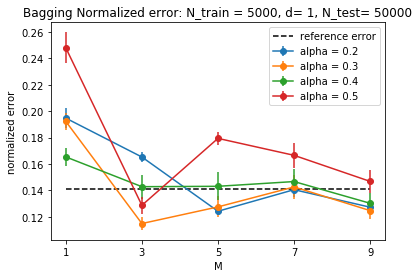

In [17]:
plt.hlines(reference_error_mean,xmin=M_grid[0],xmax=M_grid[-1],linestyles='dashed',label="reference error")
for i in range(len(alpha_grid)):
    plt.errorbar(np.array(M_grid),means[:,i],sigmas[:,i],marker ='o',label = f"alpha = {alpha_grid[i]}")
plt.title(f"Bagging Normalized error: N_train = {N_train}, d= {d}, N_test= {N_test}")
plt.xlabel("M")
plt.xticks(M_grid)
plt.ylabel("normalized error")
plt.legend(loc='upper right')
plt.savefig("hard_bagging.png")
plt.show()

## Store results

In [18]:
res_dict = {'N_train': N_train, 'N_test': N_test,'mgrid': M_grid, 'alpha_grid': alpha_grid, 'errors': converted_results.tolist()}

In [19]:
import json
import datetime
with open(f'#0005_hard_bagging_{str(datetime.date.today())}.json', 'w') as fp:
    json.dump(res_dict, fp)

In [21]:
converted_results

array([[[0.18405687, 0.19855485, 0.2017712 ],
        [0.18445979, 0.19968908, 0.19287461],
        [0.15620511, 0.16670611, 0.17330706],
        [0.23161205, 0.25864762, 0.25397623]],

       [[0.16176284, 0.16999539, 0.16423112],
        [0.11040252, 0.11271713, 0.12160244],
        [0.13004539, 0.1495795 , 0.14888737],
        [0.12220362, 0.12685371, 0.13711206]],

       [[0.12117313, 0.12795464, 0.12356273],
        [0.11650846, 0.13083649, 0.13522609],
        [0.12868414, 0.14730176, 0.15341002],
        [0.17301261, 0.17972655, 0.18560729]],

       [[0.13359486, 0.14773783, 0.1403787 ],
        [0.12992137, 0.14699154, 0.15101376],
        [0.13340449, 0.15066672, 0.15609818],
        [0.15425925, 0.16840871, 0.17713583]],

       [[0.12085441, 0.1336169 , 0.12740177],
        [0.11574074, 0.12776819, 0.13063216],
        [0.11985359, 0.13229665, 0.13863741],
        [0.13764079, 0.14461473, 0.15828688]]])